In [71]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [72]:
%reset
import matplotlib
import numpy as np
import scipy as sp
import netCDF4 as nc
import cmocean as cm
from scipy.io import loadmat
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

from salishsea_tools import visualisations as vis


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Making a thalweg plot

#### requires you to have salishsea_tools

#### in the below cell you define your parameters

#### Depth[m] and Distance along thalweg font size is fixed


In [73]:
path_to_file = '/results/SalishSea/hindcast.201905/05jun17/'
fname = 'SalishSea_1h_20170605_20170605_grid_T.nc'

variable_to_plot = 'vosaline'
hour_of_day_to_plot = 12
x_size_of_plot = 11
y_size_of_plot = 4
vmin = 20
vmax = 32
stepsize = 0.2
do_I_want_to_save_fig = False
figstr = 'name_of_fig.png'
tit = 'title of plot'
cbar_label = 'colorbar label'
titlefontsize = 20
cbarfontsize = 18
cbartickfontsize = 15
axistickfontsize = 15
#colourmap I've chosen, from https://matplotlib.org/cmocean/
t_cmap = cm.cm.haline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


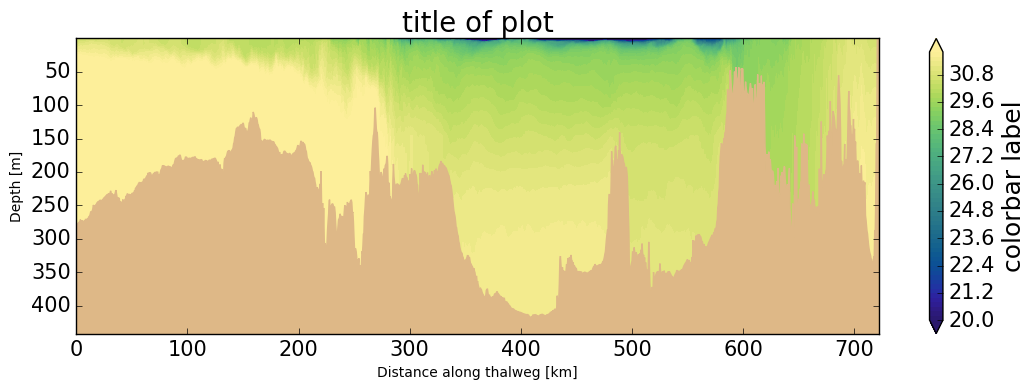

In [74]:
#bathymetry and meshmap
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')



nc_to_plot = nc.Dataset(path_to_file + fname)
data_to_plot = nc_to_plot[variable_to_plot][hour_of_day_to_plot-1,:,:,:]


fig, ax1 = plt.subplots(1,1,figsize=(x_size_of_plot,y_size_of_plot))
cbar = vis.contour_thalweg(ax1, data_to_plot, bathy, mesh, np.arange(vmin, vmax, stepsize), cmap = t_cmap)
ax1.set_title(tit , fontsize = titlefontsize)
cbar.set_label(cbar_label, fontsize = cbarfontsize)
cbar.ax.tick_params(labelsize=cbartickfontsize) 
ax1.tick_params(axis='both', which='major', labelsize=axistickfontsize)


fig.tight_layout()
plt.show()
if do_I_want_to_save_fig == True:
    fig.savefig(figstr)




In [75]:
def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)

# Thalweg map with bathymetry

#### nothing to change here


In [76]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')

def plot_map(ax, cst, bounds, grid, w_map = [-129, -121, 47, 51.2], idepth=0):
    """Plot Strait of Georgia study area on Basemap object
    """
    
    # Plot Basemap
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    dat = grid['Bathymetry'][:]
    C = ax.contourf(x, y, dat, levels=np.arange(0, 500, 10), cmap=cm.cm.deep, extend = 'both') # extend='both', zorder=.2)


    #Colorbar
    fig.subplots_adjust(bottom=0.0)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Depth [m]')
    cbar.set_label(label='Depth [m]', size=14)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    

    # Plot Thalweg
    plot_thalweg(ax, x, y)

/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


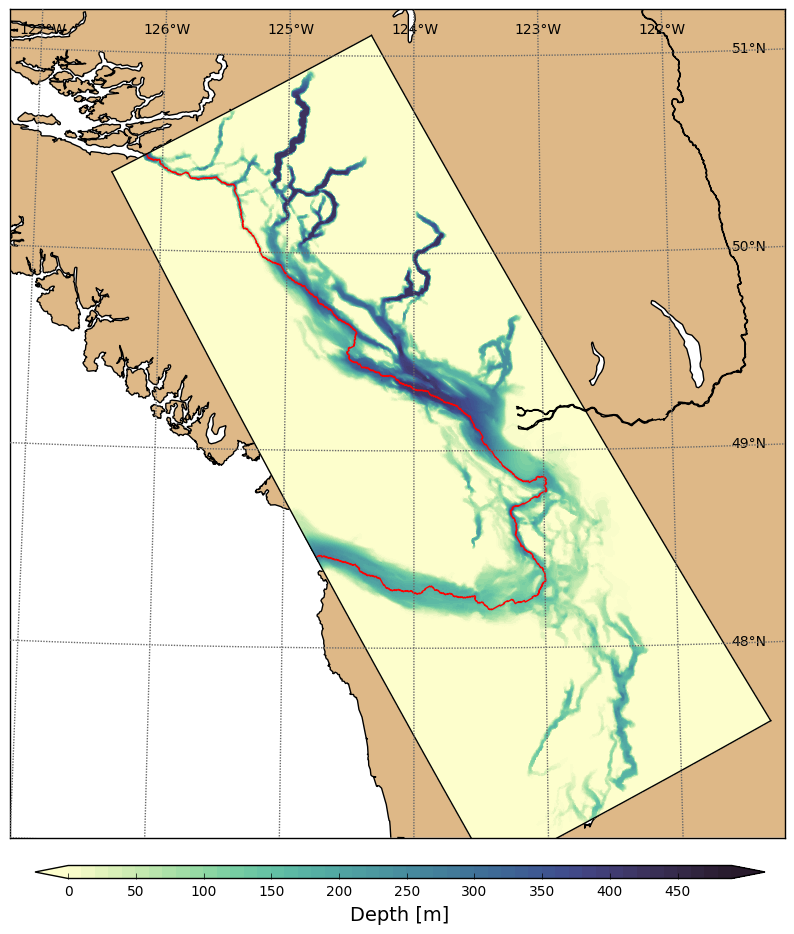

In [77]:
# Load NEMO grid
grid_NEMO = xr.open_dataset(
    '/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)


# Load Fraser coastline
PNWrivers = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')

# Define Fraser coastline regions
bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# Plot Model Domain
plot_map(ax, PNWrivers, bounds, grid_NEMO, w_map = [-127, -121, 47, 51.2], idepth=0)